# Project Stochastic and Spatial Models

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

In [121]:
import os
import pickle
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns


[CACHE] Loaded results for N=100, β=0.25
[CACHE] Loaded results for N=100, β=0.50
[CACHE] Loaded results for N=100, β=0.75
[CACHE] Loaded results for N=100, β=1.00
[CACHE] Loaded results for N=1000, β=0.25
[CACHE] Loaded results for N=1000, β=0.50
[CACHE] Loaded results for N=1000, β=0.75
[CACHE] Loaded results for N=1000, β=1.00
[CACHE] Loaded results for N=10000, β=0.25
[CACHE] Loaded results for N=10000, β=0.50
[CACHE] Loaded results for N=10000, β=0.75
[CACHE] Loaded results for N=10000, β=1.00


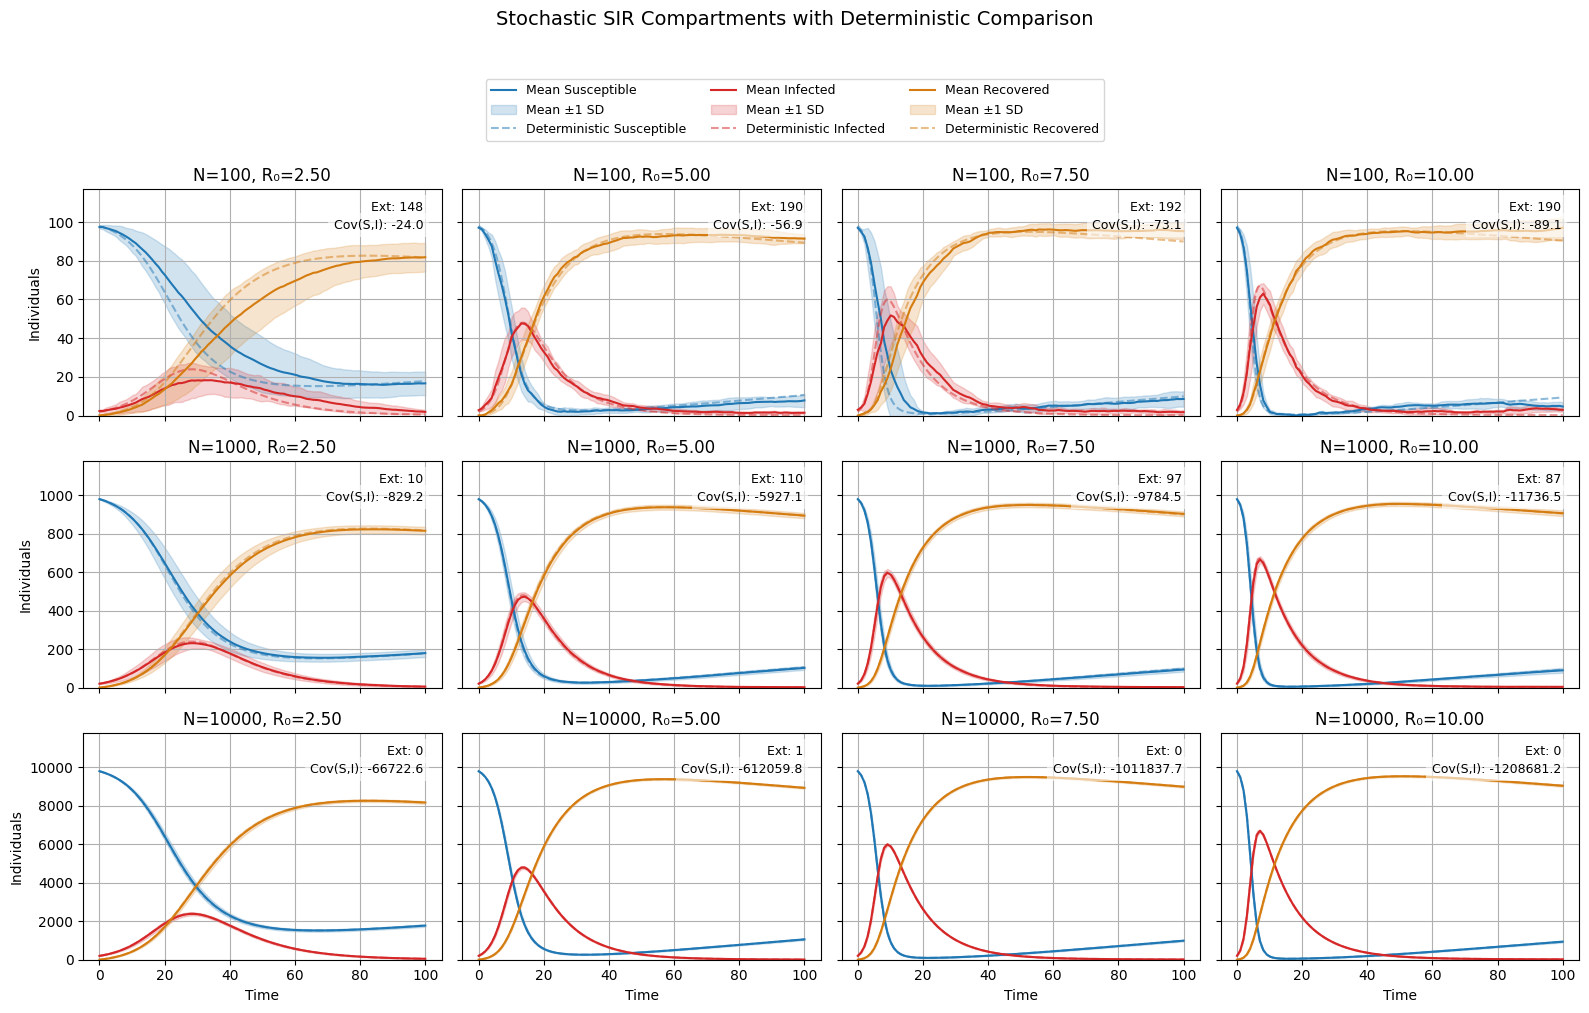

[CACHE] Loaded results for N=100, β=0.25
[CACHE] Loaded results for N=100, β=0.50
[CACHE] Loaded results for N=100, β=0.75
[CACHE] Loaded results for N=100, β=1.00
[CACHE] Loaded results for N=1000, β=0.25
[CACHE] Loaded results for N=1000, β=0.50
[CACHE] Loaded results for N=1000, β=0.75
[CACHE] Loaded results for N=1000, β=1.00
[CACHE] Loaded results for N=10000, β=0.25
[CACHE] Loaded results for N=10000, β=0.50
[CACHE] Loaded results for N=10000, β=0.75
[CACHE] Loaded results for N=10000, β=1.00
Figure saved to: data/covariance_heatmap.png


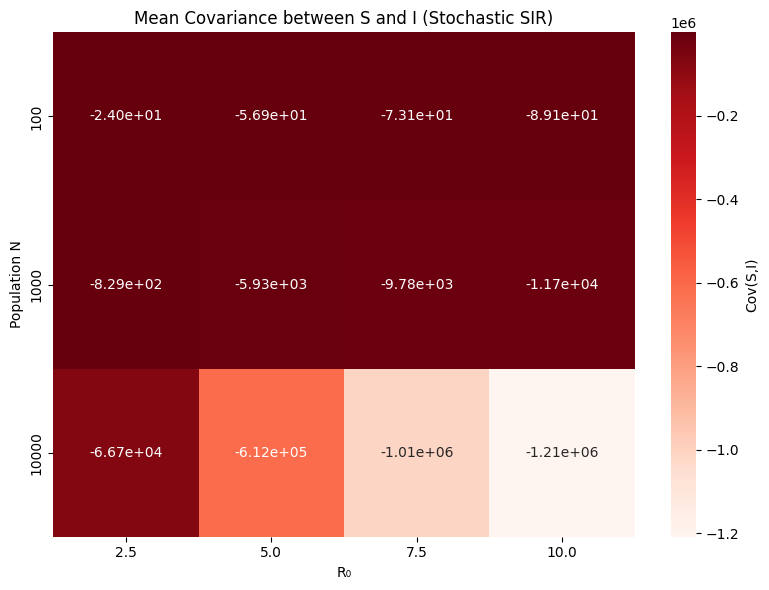

[CACHE] Loaded results for N=100, β=0.25
[CACHE] Loaded results for N=100, β=0.50
[CACHE] Loaded results for N=100, β=0.75
[CACHE] Loaded results for N=100, β=1.00
[CACHE] Loaded results for N=1000, β=0.25
[CACHE] Loaded results for N=1000, β=0.50
[CACHE] Loaded results for N=1000, β=0.75
[CACHE] Loaded results for N=1000, β=1.00
[CACHE] Loaded results for N=10000, β=0.25
[CACHE] Loaded results for N=10000, β=0.50
[CACHE] Loaded results for N=10000, β=0.75
[CACHE] Loaded results for N=10000, β=1.00
Figure saved to: data/extinction_analysis.png


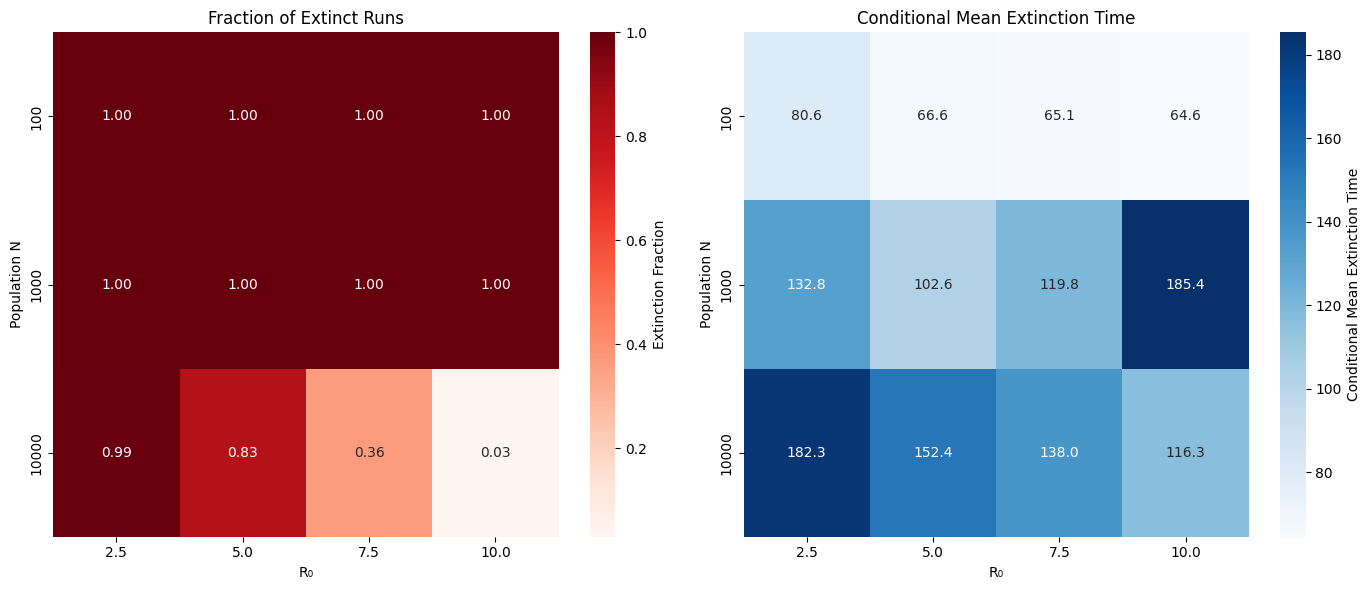

In [ ]:
def stochastic_sir(v, t, beta=1.0, gamma=0.1, mu=0.00166, debug=False):
    """
    Perform a single stochastic SIR event update using Gillespie algorithm.
    """
    x, y, z = v
    n = x + y + z

    # Total population extinction: return immediately
    if n <= 0:
        return [0, 0, 0, t]

    # Event rates
    r1 = mu * n                 # Birth
    r2 = beta * ((x * y) / n)   # Transmission
    r3 = gamma * y               # Recovery
    r4 = mu * x                  # Death of Susceptible
    r5 = mu * y                  # Death of Infected
    r6 = mu * z                  # Death of Recovered

    rates = [r1, r2, r3, r4, r5, r6]
    r_total = sum(rates)

    # If total rate is 0 (no events possible), just return current state
    if r_total <= 0:
        return [x, y, z, t]

    dt = -np.log(np.random.uniform(0, 1)) / r_total

    # State update functions
    updates = [
        lambda x, y, z: (x + 1, y, z),
        lambda x, y, z: (x - 1, y + 1, z),
        lambda x, y, z: (x, y - 1, z + 1),
        lambda x, y, z: (x - 1, y, z),
        lambda x, y, z: (x, y - 1, z),
        lambda x, y, z: (x, y, z - 1),
    ]

    # Choose event based on cumulative probability
    cumulative_rates = np.cumsum(rates)
    P = np.random.uniform(0, 1) * r_total

    for i, rate in enumerate(cumulative_rates):
        if i > 0:
            if P > cumulative_rates[i-1] and P <= rate:
                x, y, z = updates[i](x, y, z)
                break
        else:
            if P <= rate:
                x, y, z = updates[i](x, y, z)
                break

    t += dt

    # Infection extinction: return with I=0
    if y <= 0:
        return [x, 0, z, t]

    if debug:
        print(f"t={t:.4f}, dt={dt:.4f}, P={P:.4f}, S={x}, I={y}, R={z}")

    return [x, y, z, t]


def deterministic_ode(v, t, beta=1.0, gamma=0.1, mu=0.00166):
    S, I, R = v
    N = S + I + R
    dS = mu * N - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    return [dS, dI, dR]


def stochastic_run(run_time, x0, y0, z0, t0, beta, gamma, mu):
    """
    Run a single stochastic SIR simulation until run_time or until extinction.
    Returns: time series of S, I, R, and t.
    """
    xs, ys, zs, ts = [], [], [], []
    x, y, z, t = x0, y0, z0, t0

    while t < run_time:
        x, y, z, t = stochastic_sir([x, y, z], t, beta, gamma, mu)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        ts.append(t)

        # Stop if infection goes extinct
        if y <= 0:
            break

    return xs, ys, zs, ts


def stochastic_stats(
    num_runs=100,
    run_time=100.0,
    N=1000,
    beta=1.0,
    gamma=0.1,
    mu=0.00166,
    save_path="data",
    force_recompute=False
):
    """
    Run stochastic SIR to collect statistics over multiple runs.
    Records extinction times and computes conditional mean extinction time
    only for runs that actually went extinct.
    """
    os.makedirs(save_path, exist_ok=True)
    filename = os.path.join(
        save_path,
        f"SIR_N{N}_beta{beta:.3f}_gamma{gamma:.3f}_mu{mu:.5f}_runs{num_runs}_time{run_time}.pkl"
    )

    # Load cache if available
    if not force_recompute and os.path.exists(filename):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        print(f"[CACHE] Loaded results for N={N}, β={beta:.2f}")
        return data["target_t"], data["stats"], data["extinctions"]

    target_t = np.linspace(0, run_time, 100)
    all_S, all_I, all_R = [], [], []
    covariances = []
    extinction_times = []

    for i in range(num_runs):
        print(f"Running simulation {i + 1}/{num_runs} for N={N}, β={beta:.2f}", end="\r")
        y0 = int(round(0.02 * N))
        z0 = 0
        x0 = N - y0 - z0

        xs, ys, zs, ts = stochastic_run(run_time, x0=x0, y0=y0, z0=z0, t0=0,
                                        beta=beta, gamma=gamma, mu=mu)

        # Record extinction time only if infection died out
        if ys[-1] == 0:
            extinction_times.append(ts[-1])
            continue  # Do not include extinct runs in mean/std stats

        # Interpolate for non-extinct runs
        xs_interp = np.interp(target_t, ts, xs)
        ys_interp = np.interp(target_t, ts, ys)
        zs_interp = np.interp(target_t, ts, zs)
        all_S.append(xs_interp)
        all_I.append(ys_interp)
        all_R.append(zs_interp)
        covariances.append(np.cov(xs, ys)[0, 1])

    all_S = np.array(all_S)
    all_I = np.array(all_I)
    all_R = np.array(all_R)
    extinctions = num_runs - all_I.shape[0]  # number of extinct runs

    stats = {
        "S": {"mean": np.mean(all_S, axis=0), "std": np.std(all_S, axis=0)} if all_S.size else {"mean": np.zeros_like(target_t), "std": np.zeros_like(target_t)},
        "I": {"mean": np.mean(all_I, axis=0), "std": np.std(all_I, axis=0)} if all_I.size else {"mean": np.zeros_like(target_t), "std": np.zeros_like(target_t)},
        "R": {"mean": np.mean(all_R, axis=0), "std": np.std(all_R, axis=0)} if all_R.size else {"mean": np.zeros_like(target_t), "std": np.zeros_like(target_t)},
        "mean_cov_SI": np.mean(covariances) if covariances else np.nan,
        "extinction_fraction": extinctions / num_runs,
        "mean_extinction_time": np.mean(extinction_times) if extinction_times else np.nan,
        "std_extinction_time": np.std(extinction_times) if extinction_times else np.nan,
        "extinction_times": extinction_times
    }

    data = {"target_t": target_t, "stats": stats, "extinctions": extinctions}
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"[SAVED] Cached results for N={N}, β={beta:.2f}")

    return target_t, stats, extinctions


def plot_stochastic_grid(
    N_values,
    beta_values,
    num_runs=100,
    run_time=100.0,
    gamma=0.1,
    mu=0.00166,
    use_std=True,
    save_fig=False,
    save_path="data"
):
    """
    Grid of plots showing stochastic SIR results with deterministic comparison.
    """

    n_rows = len(N_values)
    n_cols = len(beta_values)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=False
    )
    axes = np.atleast_2d(axes)

    colors = {'S': '#1f77b4', 'I': '#d62728', 'R': "#d57c10"}
    compartments = ['S', 'I', 'R']
    comp_labels = ['Susceptible', 'Infected', 'Recovered']

    global_handles = []
    global_labels = []

    for i, N in enumerate(N_values):
        row_max = 0
        temp_stats = []
        temp_extinctions = []

        # Data collection pass
        for j, beta in enumerate(beta_values):
            target_t, stats, extinctions = stochastic_stats(
                num_runs=num_runs,
                run_time=run_time,
                N=N,
                beta=beta,
                gamma=gamma,
                mu=mu,
                save_path=save_path
            )
            temp_stats.append(stats)
            temp_extinctions.append(extinctions)
            row_max = max(
                row_max,
                stats['S']['mean'].max(),
                stats['I']['mean'].max(),
                stats['R']['mean'].max()
            )

        # Plotting pass
        for j, beta in enumerate(beta_values):
            ax = axes[i, j]
            stats = temp_stats[j]
            extinctions = temp_extinctions[j]

            for k, compartment in enumerate(compartments):
                mean = stats[compartment]['mean']
                color = colors[compartment]

                # Shaded std band
                if use_std:
                    std = stats[compartment]['std']
                    band = ax.fill_between(
                        target_t, mean - std, mean + std, color=color, alpha=0.2
                    )
                else:
                    band = None

                # Mean line
                line_mean, = ax.plot(target_t, mean, color=color)

                # Deterministic solution
                y0 = int(round(0.02 * N))
                z0 = 0
                S0 = N - y0 - z0
                t_span = np.linspace(0, run_time, 200)
                S_det, I_det, R_det = odeint(
                    deterministic_ode, [S0, y0, z0], t_span, args=(beta, gamma, mu)
                ).T
                det_line, = ax.plot(
                    t_span,
                    {'S': S_det, 'I': I_det, 'R': R_det}[compartment],
                    color=color,
                    linestyle='dashed',
                    alpha=0.5
                )

                # Store legend handles only once
                if i == 0 and j == 0:
                    global_handles.extend([line_mean, band, det_line])
                    global_labels.extend([
                        f'Mean {comp_labels[k]}',
                        'Mean ±1 SD' if use_std else None,
                        f'Deterministic {comp_labels[k]}'
                    ])

            # Annotations
            ax.text(
                0.95, 0.87,
                f'Cov(S,I): {stats["mean_cov_SI"]:.1f}',
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
            )

            ax.text(
                0.95, 0.95,
                f'Ext: {extinctions}',
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
            )

            # Formatting
            ax.set_ylim(bottom=0, top=row_max * 1.2)
            ax.grid(True)
            ax.set_title(f"N={N}, R₀={beta/gamma:.2f}")

            if j != 0:
                ax.set_yticklabels([])
            if i == n_rows - 1:
                ax.set_xlabel("Time")
            if j == 0:
                ax.set_ylabel("Individuals")

    # Global legend
    fig.legend(
        handles=[h for h in global_handles if h is not None],
        labels=[l for l in global_labels if l is not None],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=3,
        fontsize=9
    )

    fig.suptitle("Stochastic SIR Compartments with Deterministic Comparison", fontsize=14, y=1.12)
    plt.tight_layout()

    if save_fig:
        fig_path = os.path.join(save_path, "stochastic_sir_grid.png")
        plt.savefig(fig_path, bbox_inches='tight')
        print(f"Figure saved to: {fig_path}")

    plt.show()


def plot_covariance_heatmap(
    N_values,
    beta_values,
    num_runs=100,
    run_time=100.0,
    gamma=0.1, mu=0.00166,
    save_fig=False,
    save_path="data",
    force_recompute=False
):
    """
    Heatmap of mean covariance between S and I over varying N and beta.
    """
    n_rows, n_cols = len(N_values), len(beta_values)
    cov_matrix = np.zeros((n_rows, n_cols))

    # Compute mean covariance
    for i, N in enumerate(N_values):
        for j, beta in enumerate(beta_values):
            _, stats, _ = stochastic_stats(
                num_runs=num_runs, run_time=run_time,
                N=N, beta=beta, gamma=gamma, mu=mu,
                save_path=save_path, force_recompute=force_recompute
            )
            cov_matrix[i, j] = stats.get("mean_cov_SI", np.nan)

    # Use linear scale but map full range for better contrast
    vmin = cov_matrix.min()
    vmax = cov_matrix.max()
    fig, ax = plt.subplots(figsize=(8, 6))
    r_values = np.array(beta_values) / gamma

    sns.heatmap(
        cov_matrix, annot=True, fmt=".2e",
        xticklabels=r_values, yticklabels=N_values,
        cmap="Reds", cbar_kws={'label': 'Cov(S,I)'},
        vmin=vmin, vmax=vmax,
        ax=ax
    )

    ax.set_xlabel("R₀")
    ax.set_ylabel("Population N")
    ax.set_title("Mean Covariance between S and I (Stochastic SIR)")

    plt.tight_layout()

    if save_fig:
        os.makedirs(save_path, exist_ok=True)
        fig_path = os.path.join(save_path, "covariance_heatmap.png")
        plt.savefig(fig_path, bbox_inches="tight")
        print(f"Figure saved to: {fig_path}")

    plt.show()


def plot_transients(
    N_values,
    beta_values,
    num_runs=100,
    run_time=100.0,
    time_window=(60, 80),
    gamma=0.1,
    mu=0.00166,
    compartment='I',
    save_fig=False,
    save_path="data",
    force_recompute=False
):
    """
    Grid of zoomed-in stochastic transients around equilibrium.
    """

    # Map compartment letter to full name
    comp_full = {'I': 'Infected', 'S': 'Susceptible', 'R': 'Recovered'}
    comp_name = comp_full.get(compartment, compartment)

    n_rows = len(N_values)
    n_cols = len(beta_values)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 3 * n_rows),
        sharex=True,
        sharey=False
    )
    axes = np.atleast_2d(axes)
    color = '#d62728'

    data_cache = {}

    # Preload data for all (N, beta)
    for i, N in enumerate(N_values):
        for j, beta in enumerate(beta_values):
            target_t, stats, _ = stochastic_stats(
                num_runs=num_runs,
                run_time=run_time,
                N=N,
                beta=beta,
                gamma=gamma,
                mu=mu,
                save_path=save_path,
                force_recompute=force_recompute
            )
            data_cache[(i, j)] = (target_t, stats)

    # Plotting
    global_handles = []
    global_labels = []

    for i, N in enumerate(N_values):
        for j, beta in enumerate(beta_values):
            target_t, stats = data_cache[(i, j)]
            ax = axes[i, j]

            mask = (target_t >= time_window[0]) & (target_t <= time_window[1])
            t_zoom = target_t[mask]
            mean_zoom = stats[compartment]['mean'][mask]
            std_zoom = stats[compartment]['std'][mask]

            band = ax.fill_between(t_zoom, mean_zoom - std_zoom, mean_zoom + std_zoom,
                                   color=color, alpha=0.2)
            line_mean, = ax.plot(t_zoom, mean_zoom, color=color, lw=1.5)

            # Deterministic comparison
            y0 = int(round(0.02 * N))
            z0 = 0
            S0 = N - y0 - z0
            t_span = np.linspace(0, run_time, 200)
            S_det, I_det, R_det = odeint(
                deterministic_ode, [S0, y0, z0], t_span, args=(beta, gamma, mu)
            ).T
            det_line = {'S': S_det, 'I': I_det, 'R': R_det}[compartment]
            line_det, = ax.plot(t_span, det_line, color=color, linestyle='dashed', alpha=0.4)

            # Collect handles for global legend
            if i == 0 and j == 0:
                global_handles.extend([line_mean, band, line_det])
                global_labels.extend([
                    f'Mean {comp_name}',
                    'Mean ±1 SD',
                    f'Deterministic {comp_name}'
                ])

            # Independent y-axis
            ax.set_ylim((mean_zoom - std_zoom).min() * 0.9, (mean_zoom + std_zoom).max() * 1.1)
            ax.set_xlim(*time_window)
            ax.grid(True)
            ax.set_title(f"N={N}, R₀={beta/gamma:.2f}")

            if j == 0:
                ax.set_ylabel(f"{comp_name} individuals")
            if i == n_rows - 1:
                ax.set_xlabel("Time")

    fig.legend(
        handles=[h for h in global_handles if h is not None],
        labels=[l for l in global_labels if l is not None],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=3,
        fontsize=9
    )

    fig.suptitle(f"Transient Fluctuations in {comp_name} Individuals (Stochastic SIR)", fontsize=14, y=1.1)
    plt.tight_layout()

    if save_fig:
        os.makedirs(save_path, exist_ok=True)
        fig_path = os.path.join(save_path, f"stochastic_transients_{compartment}.png")
        plt.savefig(fig_path, bbox_inches='tight')
        print(f"Figure saved to: {fig_path}")

    plt.show()


def plot_extinction_analysis(
    N_values,
    beta_values,
    num_runs=100,
    run_time=100.0,
    gamma=0.1,
    mu=0.00166,
    save_fig=False,
    save_path="data",
    force_recompute=False
):
    """
    Plot extinction fraction and conditional mean extinction time
    as heatmaps side by side for varying N and beta.
    """
    n_rows, n_cols = len(N_values), len(beta_values)
    frac_extinct = np.zeros((n_rows, n_cols))
    mean_ext_times = np.full((n_rows, n_cols), np.nan)

    for i, N in enumerate(N_values):
        for j, beta in enumerate(beta_values):
            if force_recompute:
                print(f"\n[FORCE RECOMPUTE] N={N}, R₀={beta/gamma:.2f}")
                print(f"\nRunning N={N}, β={beta:.2f}")
            _, stats, _ = stochastic_stats(
                num_runs=num_runs,
                run_time=run_time,
                N=N,
                beta=beta,
                gamma=gamma,
                mu=mu,
                save_path=save_path,
                force_recompute=force_recompute
            )

            frac_extinct[i, j] = stats.get("extinction_fraction", np.nan)
            mean_ext_times[i, j] = stats.get("mean_extinction_time", np.nan)

    _, axes = plt.subplots(1, 2, figsize=(14, 6))
    r_values = np.array(beta_values) / gamma
    sns.heatmap(frac_extinct, annot=True, xticklabels=r_values, yticklabels=N_values,
                ax=axes[0], cmap="Reds", cbar_kws={'label': 'Extinction Fraction'}, fmt=".2f")
    axes[0].set_title("Fraction of Extinct Runs")
    axes[0].set_xlabel("R₀")
    axes[0].set_ylabel("Population N")

    sns.heatmap(mean_ext_times, annot=True, xticklabels=r_values, yticklabels=N_values,
                ax=axes[1], cmap="Blues", cbar_kws={'label': 'Conditional Mean Extinction Time'}, fmt=".1f")
    axes[1].set_title("Conditional Mean Extinction Time")
    axes[1].set_xlabel("R₀")
    axes[1].set_ylabel("Population N")

    plt.tight_layout()

    if save_fig:
        os.makedirs(save_path, exist_ok=True)
        fig_path = os.path.join(save_path, "extinction_analysis.png")
        plt.savefig(fig_path, bbox_inches="tight")
        print(f"Figure saved to: {fig_path}")

    plt.show()


plot_stochastic_grid(
    N_values=[100, 1000, 10000],
    beta_values=[0.25, 0.50, 0.75, 1.0],
    num_runs=200,
    run_time=100,
    use_std=True,
    save_fig=False,
    save_path="data"
)

plot_covariance_heatmap(
    N_values=[100, 1000, 10000],
    beta_values=[0.25, 0.50, 0.75, 1.0],
    num_runs=200,
    run_time=100,
    save_fig=False,
    save_path="data"
)

# plot_transients(
#     N_values=[500, 1000, 5000],
#     beta_values=[0.25, 0.5, 0.75],
#     num_runs=200,
#     run_time=150,
#     time_window=(0, 150),
#     gamma=0.1,
#     mu=0.0166,
#     save_fig=True,
#     save_path="data",
#     compartment='I'
# )

# plot_transients(
#     N_values=[500, 1000, 5000],
#     beta_values=[0.25, 0.5, 0.75],
#     num_runs=200,
#     run_time=150,
#     time_window=(75, 125),
#     gamma=0.1,
#     mu=0.00166,
#     save_fig=False,
#     save_path="data",
#     compartment='S'
# )

plot_extinction_analysis(
    N_values=[100, 1000, 10000],
    beta_values=[0.25, 0.50, 0.75, 1.0],
    num_runs=200,
    run_time=5000,
    save_fig=False,
    save_path="data"
)

# plot_extinction_analysis(
#     N_values=[100000],
#     beta_values=[0.75, 1.0],
#     num_runs=200,
#     run_time=5000,
#     save_fig=False,
#     save_path="data",
#     force_recompute=True
# )

# To do:    Fix Stochastic Resonance and Increased Transients
